# Chapter 15. Missing Data and Other Opportunities

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import ops, vmap
import jax.numpy as np
from jax.random import PRNGKey, shuffle
from jax.scipy.special import expit

import numpyro
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

### Code 15.1

In [2]:
# simulate a pancake and return randomly ordered sides
def sim_pancake(seed):
    pancake = dist.Categorical(logits=np.ones(3)).sample(PRNGKey(2 * seed))
    sides = np.array([1, 1, 1, 0, 0, 0]).reshape(3, 2).T[:, pancake]
    return shuffle(PRNGKey(2 * seed + 1), sides)

# sim 10,000 pancakes
pancakes = vmap(sim_pancake, out_axes=1)(np.arange(10000))
up = pancakes[0]
down = pancakes[1]

# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up == 1)
num_11 = np.sum((up == 1) & (down == 1))
num_11 / num_11_10

DeviceArray(0.6760591, dtype=float32)

### Code 15.2

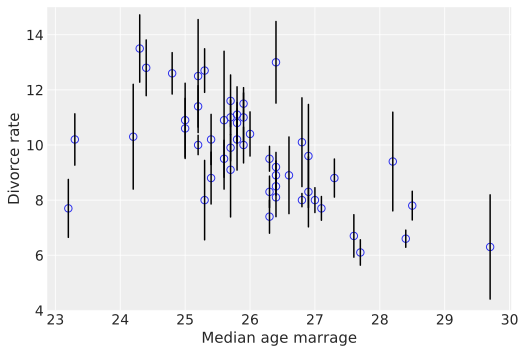

In [3]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# points
ax = az.plot_pair(d[["MedianAgeMarriage", "Divorce"]].to_dict(orient="list"),
                  plot_kwargs=dict(ms=15, mfc="none"))
ax.set(ylim=(4, 15), xlabel="Median age marrage", ylabel="Divorce rate")

# standard errors
for i in range(d.shape[0]):
    ci = d.Divorce[i] + np.array([-1, 1]) * d["Divorce SE"][i]
    x = d.MedianAgeMarriage[i]
    plt.plot([x, x], ci, "k")

### Code 15.3

In [4]:
dlist = dict(
    D_obs=d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values,
    D_sd=d["Divorce SE"].values / d.Divorce.std(),
    M=d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    A=d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    N=d.shape[0])

def model(A, M, D_sd, D_obs, N):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A + bM * M
    D_true = numpyro.sample("D_true", dist.Normal(mu, sigma))
    numpyro.sample("D_obs", dist.Normal(D_true, D_sd), obs=D_obs)

m15_1 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_1.run(PRNGKey(0), **dlist)

### Code 15.4

In [5]:
m15_1.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
 D_true[0]      1.16      0.37      1.16      0.61      1.76   2417.37      1.00
 D_true[1]      0.70      0.55      0.68     -0.21      1.56   2984.25      1.00
 D_true[2]      0.43      0.34      0.43     -0.08      0.95   2992.93      1.00
 D_true[3]      1.41      0.48      1.42      0.69      2.18   2892.45      1.00
 D_true[4]     -0.90      0.13     -0.90     -1.11     -0.70   3769.52      1.00
 D_true[5]      0.67      0.40      0.66      0.03      1.29   4076.81      1.00
 D_true[6]     -1.37      0.36     -1.37     -1.94     -0.80   4089.29      1.00
 D_true[7]     -0.34      0.49     -0.34     -1.12      0.43   3567.06      1.00
 D_true[8]     -1.88      0.59     -1.88     -2.76     -0.86   2270.06      1.00
 D_true[9]     -0.62      0.17     -0.62     -0.90     -0.37   3937.60      1.00
D_true[10]      0.76      0.28      0.76      0.31      1.20   3041.16      1.00
D_true[11]     -0.55      0

### Code 15.5

In [6]:
dlist = dict(
    D_obs=d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values,
    D_sd=d["Divorce SE"].values / d.Divorce.std(),
    M_obs=d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    M_sd=d["Marriage SE"].values / d.Marriage.std(),
    A=d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    N=d.shape[0])

def model(A, M_sd, M_obs, D_sd, D_obs, N):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    M_est = numpyro.sample("M_est", dist.Normal(0, 1), sample_shape=(N,))
    numpyro.sample("M_obs", dist.Normal(M_est, M_sd), obs=M_obs)
    mu = a + bA * A + bM * M_est
    D_est = numpyro.sample("D_est", dist.Normal(mu, sigma))
    numpyro.sample("D_obs", dist.Normal(D_est, D_sd), obs=D_obs)

m15_2 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_2.run(PRNGKey(0), **dlist)

### Code 15.6

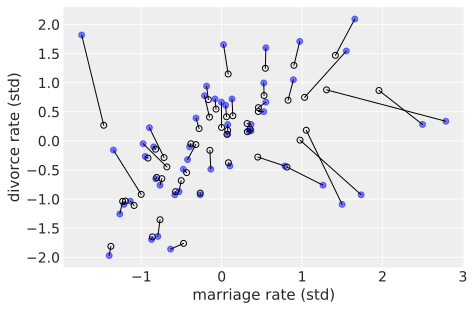

In [7]:
post = m15_2.get_samples()
D_est = np.mean(post["D_est"], 0)
M_est = np.mean(post["M_est"], 0)
plt.plot(dlist["M_obs"], dlist["D_obs"], "bo", alpha=0.5)
plt.gca().set(xlabel="marriage rate (std)", ylabel="divorce rate (std)")
plt.plot(M_est, D_est, "ko", mfc="none")
for i in range(d.shape[0]):
    plt.plot([dlist["M_obs"][i], M_est[i]], [dlist["D_obs"][i], D_est[i]],
             "k-", lw=1)

### Code 15.7

In [8]:
N = 500
A = dist.Normal().sample(PRNGKey(0), (N,))
M = dist.Normal(-A).sample(PRNGKey(1))
D = dist.Normal(A).sample(PRNGKey(2))
A_obs = dist.Normal(A).sample(PRNGKey(3))

### Code 15.8

In [9]:
N = 100
S = dist.Normal().sample(PRNGKey(0), (N,))
H = dist.Binomial(10, expit(S)).sample(PRNGKey(1))

### Code 15.9

In [10]:
D = dist.Bernoulli(0.5).sample(PRNGKey(2))  # dogs completely random
Hm = np.where(D == 1, np.nan, H)

### Code 15.10

In [11]:
D = np.where(S > 0, 1, 0)
Hm = np.where(D == 1, np.nan, H)

### Code 15.11

In [12]:
with numpyro.handlers.seed(rng_seed=501):
    N = 1000
    X = numpyro.sample("X", dist.Normal(), sample_shape=(N,))
    S = numpyro.sample("S", dist.Normal(), sample_shape=(N,))
    H = numpyro.sample("H", dist.Binomial(10, logits=2 + S - 2 * X))
    D = np.where(X > 1, 1, 0)
    Hm = np.where(D == 1, np.nan, H)

### Code 15.12

In [13]:
dat_list = dict(H=H, S=S)

def model(S, H):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bS = numpyro.sample("bS", dist.Normal(0, 0.5))
    logit_p = a + bS * S
    numpyro.sample("H", dist.Binomial(10, logits=logit_p), obs=H)

m15_3 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_3.run(PRNGKey(0), **dat_list)
m15_3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.29      0.02      1.29      1.25      1.33   1528.55      1.00
        bS      0.58      0.03      0.58      0.54      0.62   1271.14      1.00

Number of divergences: 0


### Code 15.13

In [14]:
dat_list0 = dict(H=H[D == 0], S=S[D == 0])

def model(S, H):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bS = numpyro.sample("bS", dist.Normal(0, 0.5))
    logit_p = a + bS * S
    numpyro.sample("H", dist.Binomial(10, logits=logit_p), obs=H)

m15_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_4.run(PRNGKey(0), **dat_list0)
m15_4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.86      0.03      1.86      1.80      1.91    997.61      1.00
        bS      0.65      0.03      0.65      0.59      0.70   1034.76      1.00

Number of divergences: 0


### Code 15.14

In [15]:
D = np.where(np.abs(X) < 1, 1, 0)

### Code 15.15

In [16]:
N = 100
S = dist.Normal().sample(PRNGKey(0), (N,))
H = dist.Binomial(10, logits=S).sample(PRNGKey(1))
D = np.where(H < 5, 1, 0)
Hm = np.where(D == 1, np.nan, H)

### Code 15.16

In [17]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d["neocortex.prop"] = d["neocortex.perc"] / 100
d["logmass"] = d.mass.pipe(onp.log)

### Code 15.17

In [18]:
dat_list = dict(
    K=d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std()).values,
    B=d["neocortex.prop"].pipe(lambda x: (x - x.mean()) / x.std()).values,
    M=d.logmass.pipe(lambda x: (x - x.mean()) / x.std()).values)

def model(B, M, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5))
    nu = numpyro.sample("nu", dist.Normal(0, 0.5))
    bB = numpyro.sample("bB", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma_B = numpyro.sample("sigma_B", dist.Exponential(1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    B_impute = numpyro.param("B_impute", np.zeros(onp.isnan(B).sum()))
    B = ops.index_update(B, onp.nonzero(onp.isnan(B))[0], B_impute)
    numpyro.sample("B", dist.Normal(nu, sigma_B), obs=B)
    mu = a + bB * B + bM * M
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m15_3 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_3.run(PRNGKey(0), **dat_list)

### Code 15.18

In [19]:
m15_3.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
 B_impute[0]     -0.54      0.94     -0.54     -1.99      0.98   2001.19      1.00
 B_impute[1]     -0.67      0.93     -0.68     -2.14      0.69   1698.09      1.00
 B_impute[2]     -0.71      0.93     -0.72     -2.13      0.80   1911.13      1.00
 B_impute[3]     -0.28      0.89     -0.27     -1.64      1.18   1900.20      1.00
 B_impute[4]      0.46      0.95      0.48     -0.95      2.04   2230.10      1.00
 B_impute[5]     -0.20      0.87     -0.19     -1.59      1.16   2312.67      1.00
 B_impute[6]      0.21      0.87      0.22     -1.05      1.64   2164.04      1.00
 B_impute[7]      0.28      0.89      0.28     -1.03      1.73   1809.97      1.00
 B_impute[8]      0.47      0.93      0.53     -1.04      1.89   1602.35      1.00
 B_impute[9]     -0.44      0.95     -0.46     -1.97      1.03   1723.26      1.00
B_impute[10]     -0.29      0.87     -0.30     -1.60      1.10   2063.17      1.00
B_i

### Code 15.19

In [20]:
obs_idx = ~onp.isnan(d["neocortex.prop"].values)
dat_list_obs = dict(K=dat_list["K"][obs_idx],
                    B=dat_list["B"][obs_idx],
                    M=dat_list["M"][obs_idx])

def model(B, M, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5))
    nu = numpyro.sample("nu", dist.Normal(0, 0.5))
    bB = numpyro.sample("bB", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma_B = numpyro.sample("sigma_B", dist.Exponential(1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("B", dist.Normal(nu, sigma_B), obs=B)
    mu = a + bB * B + bM * M
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m15_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_4.run(PRNGKey(0), **dat_list_obs)
m15_4.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.10      0.20      0.10     -0.21      0.40   2319.53      1.00
        bB      0.59      0.28      0.61      0.19      1.05   1127.87      1.00
        bM     -0.63      0.25     -0.64     -1.03     -0.25   1125.74      1.00
        nu      0.00      0.23     -0.00     -0.38      0.37   2095.51      1.00
     sigma      0.88      0.18      0.85      0.59      1.13   1575.27      1.00
   sigma_B      1.04      0.19      1.01      0.75      1.30   1983.85      1.00

Number of divergences: 0


### Code 15.20

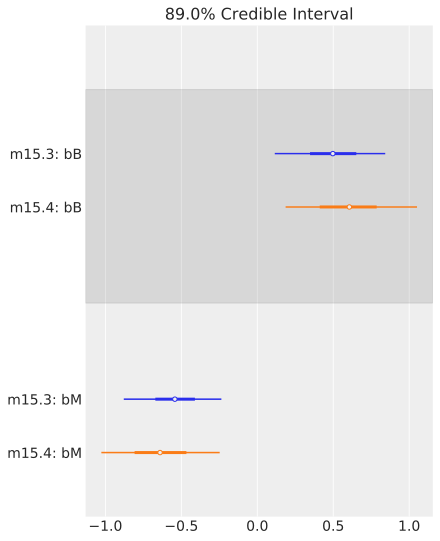

In [21]:
az.plot_forest([az.from_numpyro(m15_3), az.from_numpyro(m15_4)],
               model_names=["m15.3", "m15.4"], var_names=["bB", "bM"],
               combined=True, credible_interval=0.89);

### Code 15.21

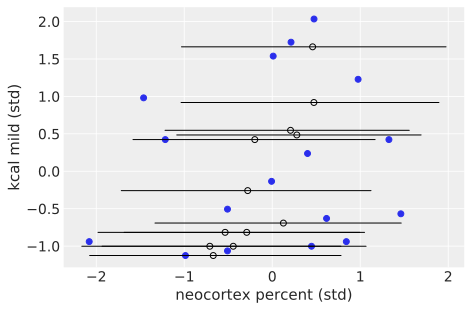

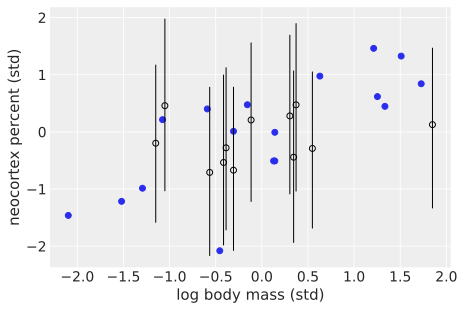

In [22]:
post = m15_3.get_samples()
B_impute_mu = np.mean(post["B_impute"], 0)
B_impute_ci = np.percentile(post["B_impute"], q=(5.5, 94.5), axis=0)

# B vs K
plt.plot(dat_list["B"], dat_list["K"], "o")
plt.gca().set(xlabel="neocortex percent (std)", ylabel="kcal mild (std)")
miss_idx = onp.nonzero(onp.isnan(dat_list["B"]))[0]
Ki = dat_list["K"][miss_idx]
plt.plot(B_impute_mu, Ki, "ko", mfc="none")
for i in range(12):
    plt.plot(B_impute_ci[:, i], np.repeat(Ki[i], 2), "k", lw=1)
plt.show()

# M vs B
plt.plot(dat_list["M"], dat_list["B"], "o")
plt.gca().set(xlabel="log body mass (std)", ylabel="neocortex percent (std)")
Mi = dat_list["M"][miss_idx]
plt.plot(Mi, B_impute_mu, "ko", mfc="none")
for i in range(12):
    plt.plot(np.repeat(Mi[i], 2), B_impute_ci[:, i], "k", lw=1)

### Code 15.22

In [23]:
def model(B, M, K):
    # priors
    a = numpyro.sample("a", dist.Normal(0, 0.5))
    muB = numpyro.sample("muB", dist.Normal(0, 0.5))
    muM = numpyro.sample("muM", dist.Normal(0, 0.5))
    bB = numpyro.sample("bB", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho_BM = numpyro.sample("Rho_BM", dist.LKJ(2, 2))
    Sigma_BM = numpyro.sample("Sigma_BM", dist.Exponential(1), sample_shape=(2,))

    # define B_merge as mix of observed and imputed values
    B_impute = numpyro.param("B_impute", np.zeros(onp.isnan(B).sum()))
    B_merge = ops.index_update(B, onp.nonzero(onp.isnan(B))[0], B_impute)

    # M and B correlation
    MB = np.stack([M, B_merge], axis=1)
    cov = np.outer(Sigma_BM, Sigma_BM) * Rho_BM
    numpyro.sample("MB", dist.MultivariateNormal(np.stack([muM, muB]), cov),
                 obs=MB)

    # K as function of B and M
    mu = a + bB * B_merge + bM * M
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m15_5 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_5.run(PRNGKey(0), **dat_list)
post = m15_5.get_samples(group_by_chain=True)
print_summary({k: v for k, v in post.items() if k in ["bM", "bB", "Rho_BM"]})


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
Rho_BM[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
Rho_BM[0,1]      0.60      0.13      0.62      0.41      0.82   1500.42      1.00
Rho_BM[1,0]      0.60      0.13      0.62      0.41      0.82   1500.42      1.00
Rho_BM[1,1]      1.00      0.00      1.00      1.00      1.00   1440.31      1.00
         bB      0.59      0.26      0.60      0.18      1.02   1083.74      1.00
         bM     -0.65      0.22     -0.66     -1.03     -0.32   1202.18      1.00



### Code 15.23

In [24]:
B_missidx = onp.nonzero(onp.isnan(dat_list["B"]))[0]

### Code 15.24

In [25]:
Moralizing_gods = pd.read_csv("../data/Moralizing_gods.csv", sep=";")
Moralizing_gods

,polity,year,population,moralizing_gods,writing
0,Big Island Hawaii,1000,3.729643,NaN,0
1,Big Island Hawaii,1100,3.729643,NaN,0
2,Big Island Hawaii,1200,3.598340,NaN,0
3,Big Island Hawaii,1300,4.026240,NaN,0
4,Big Island Hawaii,1400,4.311767,NaN,0
...,...,...,...,...,...
859,Yemeni Coastal Plain,1400,6.763083,1.0,1
860,Yemeni Coastal Plain,1500,6.519621,1.0,1
861,Konya Plain,1600,7.447158,1.0,1
862,Yemeni Coastal Plain,1700,3.882606,1.0,1


### Code 15.25

In [26]:
Moralizing_gods.moralizing_gods.value_counts(dropna=False)

NaN    528
1.0    319
0.0     17
Name: moralizing_gods, dtype: int64

### Code 15.26

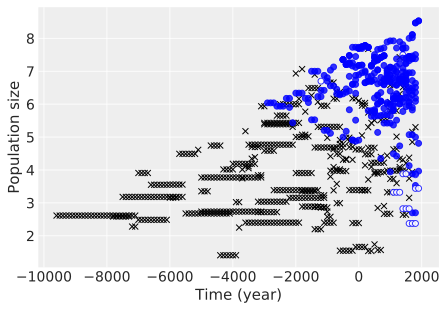

In [27]:
symbol = onp.where(Moralizing_gods.moralizing_gods.values == 1, "b", "w")
isnan = onp.isnan(Moralizing_gods.moralizing_gods.values)
symbol = onp.where(isnan, "k", symbol)
plt.scatter(Moralizing_gods.year[isnan], Moralizing_gods.population[isnan],
            marker="x", color="k", facecolor=symbol[isnan], lw=1)
plt.scatter(Moralizing_gods.year[~isnan], Moralizing_gods.population[~isnan],
            marker="o", color="b", facecolor=symbol[~isnan], alpha=0.8)
plt.gca().set(xlabel="Time (year)", ylabel="Population size");

### Code 15.27

In [28]:
dmg = Moralizing_gods
dmg.astype(str).groupby(["moralizing_gods", "writing"]).size().unstack(
    fill_value=0)

writing,0,1
moralizing_gods,,
0.0,16,1
1.0,9,310
nan,442,86


### Code 15.28

In [29]:
dmg = Moralizing_gods
haw = dmg.polity == "Big Island Hawaii"
dmg.loc[haw, ["year", "population", "writing", "moralizing_gods"]].T.round(3)

,0,1,2,3,4,5,6,7,8
year,1000.00,1100.00,1200.000,1300.000,1400.000,1500.000,1600.000,1700.000,1800.000
population,3.73,3.73,3.598,4.026,4.312,4.205,4.374,5.158,4.997
writing,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
moralizing_gods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000


### Code 15.29

In [30]:
with numpyro.handlers.seed(rng_seed=9):
    N_houses = 100
    alpha = 5
    beta = -3
    k = 0.5
    r = 0.2
    cat = numpyro.sample("cat", dist.Bernoulli(k), sample_shape=(N_houses,))
    notes = numpyro.sample("notes", dist.Poisson(alpha + beta * cat))
    R_C = numpyro.sample("R_C", dist.Bernoulli(r), sample_shape=(N_houses,))
    cat_obs = np.where(R_C == 1, -9, cat)

### Code 15.30

In [31]:
dat = dict(notes=notes, cat=cat_obs, RC=R_C, N=N_houses - 1)

def model(N, RC, cat, notes):
    # priors
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 0.5))

    # sneaking cat model
    k = numpyro.sample("k", dist.Beta(2, 2))
    numpyro.sample("cat|RC==0", dist.Bernoulli(k), obs=cat[RC == 0])

    # singing bird model
    # cat NA:
    custom_logprob = np.logaddexp(
        np.log(k) + dist.Poisson(np.exp(a + b)).log_prob(notes[RC == 1]),
        np.log(1 - k) + dist.Poisson(np.exp(a)).log_prob(notes[RC == 1]))
    numpyro.sample("notes|RC==1", dist.Delta(log_density=custom_logprob), obs=0.)
    # cat known present/absent:
    lambda_ = np.exp(a + b * cat[RC == 0])
    numpyro.sample("notes|RC==0", dist.Poisson(lambda_), obs=notes[RC == 0])

m15_6 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_6.run(PRNGKey(0), **dat)

### Code 15.31

In [32]:
def model(N, RC, cat, notes, link=False):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 0.5))

    # sneaking cat model
    k = numpyro.sample("k", dist.Beta(2, 2))
    numpyro.sample("cat|RC==0", dist.Bernoulli(k), obs=cat[RC == 0])

    # singing bird model
    custom_logprob = np.logaddexp(
        np.log(k) + dist.Poisson(np.exp(a + b)).log_prob(notes[RC == 1]),
        np.log(1 - k) + dist.Poisson(np.exp(a)).log_prob(notes[RC == 1]))
    numpyro.sample("notes|RC==1", dist.Delta(log_density=custom_logprob), obs=0.)
    lambda_ = np.exp(a + b * cat[RC == 0])
    numpyro.sample("notes|RC==0", dist.Poisson(lambda_), obs=notes[RC == 0])

    if link:
        lpC0 = np.log(1 - k) + dist.Poisson(np.exp(a)).log_prob(notes)
        lpC1 = np.log(k) + dist.Poisson(np.exp(a + b)).log_prob(notes)
        PrC1 = np.exp(lpC1) / (np.exp(lpC1) + np.exp(lpC0))
        numpyro.sample("lpC0", dist.Delta(lpC0), obs=lpC0)
        numpyro.sample("lpC0", dist.Delta(lpC1), obs=lpC1)
        numpyro.sample("lpC0", dist.Delta(PrC1), obs=PrC1)

m15_7 = MCMC(NUTS(model), 500, 500, num_chains=4)
m15_7.run(PRNGKey(0), **dat)

### Code 15.32

In [33]:
with numpyro.handlers.seed(rng_seed=100):
    x = numpyro.sample("x", dist.Normal(), sample_shape=(10,))
    y = numpyro.sample("y", dist.Normal(x))
    x = np.concatenate([x, np.array([np.nan])])
    y = np.concatenate([y, np.array([100])])
    d = dict(x=x, y=y)